# Los Angeles Weather Forecasting

## Introduction
Over 5 million people die each year globally because of excessively hot or cold conditions

(source: [
Extreme temperatures kill 5 million people a year with heat-related deaths rising, study finds](https://www.theguardian.com/world/2021/jul/08/extreme-temperatures-kill-5-million-people-a-year-with-heat-related-deaths-rising-study-finds)).

Also; it has been important to correctly forecast weather in order to increase efficiency and avoid possible accidents in many sectors like agriculture and aviation.

Weather data used in this project is generated by [NOAA](https://www.noaa.gov/).

NOAA data can be used without any further permission as stated in [Use of Digital Media created by NOAA](https://sos.noaa.gov/copyright/#:~:text=A%20recording%20may%20be%20reproduced,obtained%20from%20the%20copyright%20owner).


## Defining The Task

Minimum and maximum temperature ranges for the next 1 week to 3 months horizon will be forecasted.

Forecast Origin: June 30, 2022

Forecast Horizon: 1-week to 3-months

Lead Time: 0 days


## Importing Necessary Libraries

In [43]:
# Upgrade statsmodels to get the function DeterministicProcess
!pip install --upgrade --no-deps statsmodels 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
# Libraries for Data Manipulation
import pandas as pd
import numpy as np

# Libraries for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Analysis Libraries
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier, Fourier
from statsmodels.graphics.tsaplots import seasonal_plot
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
import math
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# metrics
from sklearn.metrics import mean_absolute_error


# For System and Terminal Bash control
import os
from warnings import simplefilter # To remove unnecessary warnings

## Data Preperation



### Loading The data

The data has been sent by NOAA through e-mail after requesting an order from [CDO](https://www.ncei.noaa.gov/cdo-web/)

To avoid manuelly uploading data in every session, the data has been uploaded to Google Drive as publicly available. The code in the cell below will download the file with the specified id from Google drive. 

The data can also be manuelly downloaded through the link: [LA Weather Data](https://drive.google.com/uc?id=1O-7DuL6-bkPBpz7mAUZ7M62P6EOyngG2)

In [45]:
!gdown 1O-7DuL6-bkPBpz7mAUZ7M62P6EOyngG2

Downloading...
From: https://drive.google.com/uc?id=1O-7DuL6-bkPBpz7mAUZ7M62P6EOyngG2
To: /content/LA_weather.csv
100% 1.87M/1.87M [00:00<00:00, 153MB/s]


### Understanding The Data

The downloaded data is in csv form. To open a csv file in a Pandas DataFrame form, read_csv function of Pandas module has been used.


In [46]:
weather_data = pd.read_csv("LA_weather.csv")
weather_data.head()

,STATION,NAME,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,USW00023174,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",1972-07-01,NaN,0.0,0.0,0.0,NaN,73.0,62.0
1,USW00023174,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",1972-07-02,NaN,0.0,0.0,0.0,NaN,71.0,62.0
2,USW00023174,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",1972-07-03,NaN,0.0,0.0,0.0,NaN,70.0,61.0
3,USW00023174,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",1972-07-04,NaN,0.0,0.0,0.0,NaN,73.0,61.0
4,USW00023174,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",1972-07-05,NaN,0.0,0.0,0.0,NaN,72.0,60.0


There are 18262 rows and 10 columns representing 18262 days (every day between 1972, july and 2022, june) and 10 features.

Features AWND	PRCP	SNOW	SNWD	TAVG	TMAX	TMIN represent the daily weather measurements conducted in the Los Angeles Airport in the specified date for each row.

### Handling the null values

The code below will show how many null values are in data for each column.

In [47]:
weather_data.isnull().sum(axis = 0)

STATION        0
NAME           0
DATE           0
AWND        4207
PRCP           1
SNOW        9132
SNWD        8463
TAVG       12219
TMAX           1
TMIN           1
dtype: int64

AWND, SNOW and SNWD, TAVG columns are dropped because of many null values present in them.

Station and name columns are also dropped because they have little importance on the task.

Remaining DATE, TMIN and TMAX columns will be used in the analysis.

In [48]:
weather_data = weather_data[["DATE", "TMIN","TMAX"]]

Columns have been renamed.

In [49]:
weather_data.columns = ["Date", "TMin", "TMax"]

In [50]:
is_nan = weather_data.isnull()
row_has_NaN = is_nan.any(axis=1)
rows_with_nan = weather_data[row_has_NaN]

# The only row remaining with NaNs
rows_with_nan

,Date,TMin,TMax
18254,2022-06-23,NaN,NaN


As there is only one row remaining with NaN values, the manuel injection from previous row will be used to replace NaN.

In [51]:
simplefilter("ignore")
weather_data.fillna(method="bfill", inplace=True)

TMin and TMax columns are recorded in Fahrenhait. However, it's easier to work with Kelvin measurements. Following cell will generate a column with appropriate Kelvin and Celcius values.

In [52]:
# turn the data to Kelvin
weather_data.loc[:,"TMinK"] = ((weather_data["TMin"] -32)* 5/9 + 273.15).map(lambda x:int(x))
weather_data.loc[:,"TMaxK"] = ((weather_data["TMax"] -32)* 5/9 + 273.15).map(lambda x:int(x))

# Also add Celcius columns
weather_data.loc[:,"TMinC"] = ((weather_data["TMin"] -32)* 5/9 ).map(lambda x:int(x))
weather_data.loc[:,"TMaxC"] = ((weather_data["TMax"] -32)* 5/9 ).map(lambda x:int(x))

# add fahrenhait columns
weather_data.loc[:,"TMinF"] = ((weather_data["TMin"]).map(lambda x: int(x)))
weather_data.loc[:,"TMaxF"] = ((weather_data["TMax"]).map(lambda x: int(x)))

The Date column has been set as index.

In [53]:
weather_data.set_index("Date")

,TMin,TMax,TMinK,TMaxK,TMinC,TMaxC,TMinF,TMaxF
Date,,,,,,,,
1972-07-01,62.0,73.0,289,295,16,22,62,73
1972-07-02,62.0,71.0,289,294,16,21,62,71
1972-07-03,61.0,70.0,289,294,16,21,61,70
1972-07-04,61.0,73.0,289,295,16,22,61,73
1972-07-05,60.0,72.0,288,295,15,22,60,72
...,...,...,...,...,...,...,...,...
2022-06-26,62.0,72.0,289,295,16,22,62,72
2022-06-27,62.0,73.0,289,295,16,22,62,73
2022-06-28,63.0,74.0,290,296,17,23,63,74


### Global Variables

In [54]:
# Global variables
colors = ["Orange", "Blue"]
skip_days = 50 # plot once for 50 days to reduce x density
x_tick_step = 11 # there will be 11 labels in total in the plot

#### Setting the unit
Below cell sets the unit; enter following letters for selecting the unit


*   K: Kelvin
*   C: Celcius
*   F: Fahranhait

In [55]:
unit = "C"

### Trimming the Data

Unnecessary columns have been removed to ease further computings.

In [56]:
weather_data = weather_data[["Date", "TMin"+unit,	"TMax" + unit]]

### Setting the index of dataset

In [57]:
# Set the index as the column "Date"
weather_data = weather_data.set_index("Date") 

### Plotting the Data 

In [58]:
# Some Plot Stylings
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

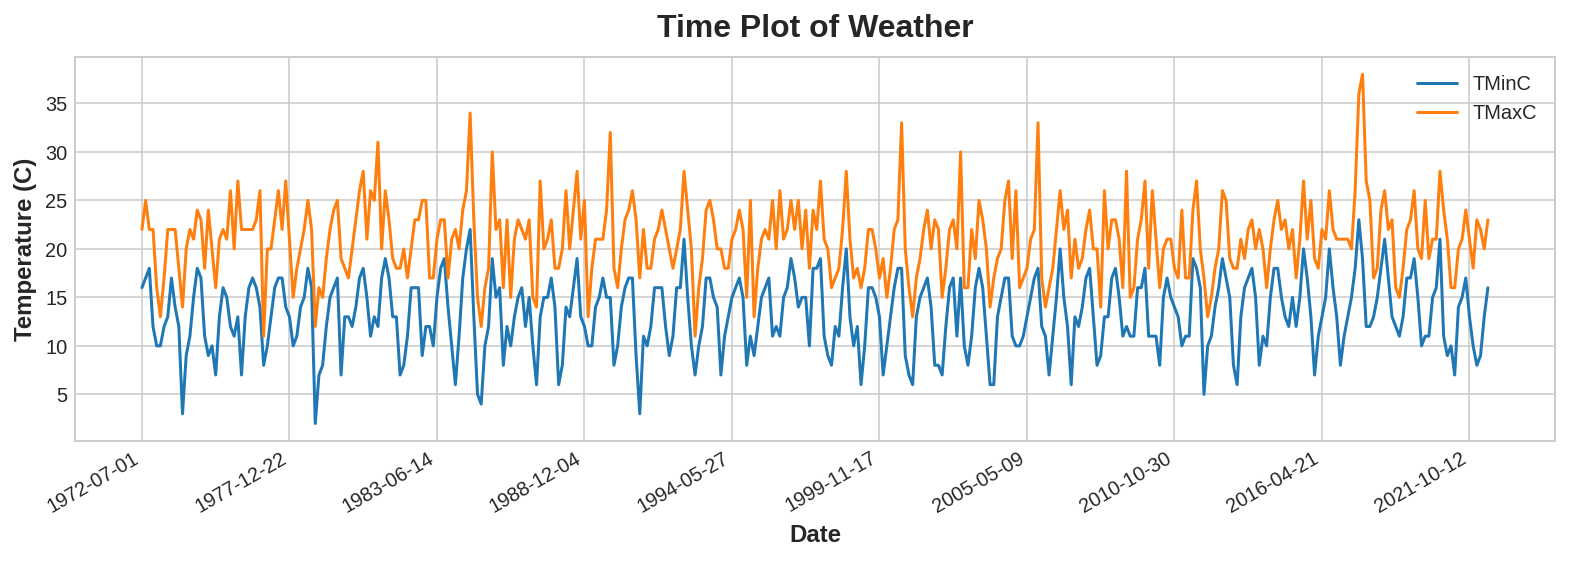

In [59]:
fig, ax = plt.subplots()
for i,col in enumerate(weather_data.columns):
  # plot temperatures against date
  ax.plot(weather_data[::skip_days].index, col, data=weather_data[::skip_days])

# set labels
ax.set_xlabel("Date")
ax.set_ylabel("Temperature ("+unit+")")

# set ticks
ax.xaxis.set_major_locator(plt.MaxNLocator(x_tick_step))

ax.legend()
fig.autofmt_xdate()
ax.set_title('Time Plot of Weather');

## Machine Learning

**Method:** Trends, seasonality and cycles will be calculated seperately.

### Trend
Trend component of a time series represents a persistent, long-term change in the mean of the series.

In the case of weather analysis; the trend is expected to be linear with a slightly(about 0.08 Celcius per decade or .4 celcius in the span of 50 years) positive slope.

In [60]:
dp = DeterministicProcess(
    index = weather_data[::].index, # Date values
    constant = True,                         # Bias
    order=1,                                 # Linear Trend
    drop=True                                # Drop terms if necessary to avoid collinearity
)
# in_sample creates features for the dates given in the 'index' argument
X = dp.in_sample()

#### Generating Trend Lines

model_max will fit a line for maximum temperatures.
model_min will fit a line for minimum temperatures.

Predictions will be generated from each model seperately and then combined into a dataFrame object called y_pred.

In [61]:
y_max = weather_data['TMax'+unit][::]                     # Creating the target
model_max_trend = LinearRegression(fit_intercept = False) # Defining the model
model_max_trend.fit(X, y_max)                             # Fitting the model

# Getting predictions from the model
Max_prediction = pd.Series(model_max_trend.predict(X), index = X.index, name = "Max Prediction")

In [62]:
y_min = weather_data["TMin"+unit][::]                     # Creating the target
model_min_trend = LinearRegression(fit_intercept= False)  # Defining the model
model_min_trend.fit(X, y_min)                             # Fitting the model

# Getting predictions from the model
Min_prediction = pd.Series(model_min_trend.predict(X), index = X.index, name="Min. Prediction")
y_pred_trend = pd.concat([Max_prediction, Min_prediction], axis = 1)

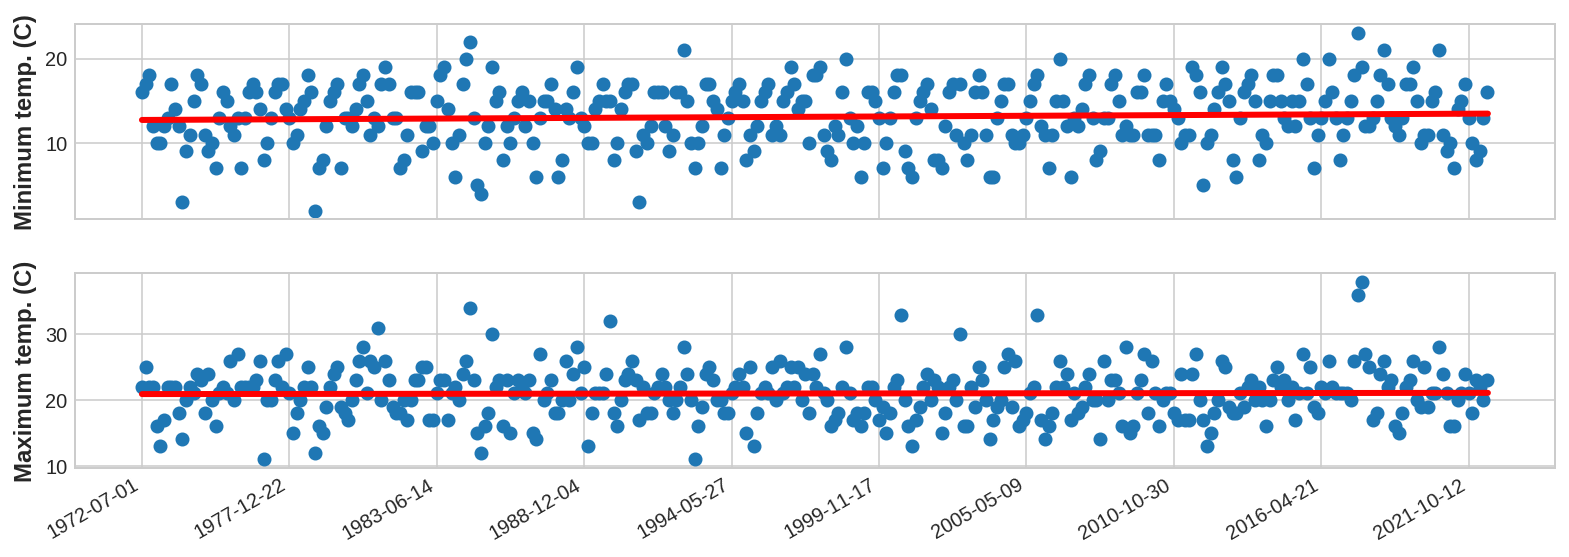

In [63]:
fig, axes = plt.subplots(2)
cols_0 = ["TMin"+unit, "TMax"+unit]
cols = [ "Min. Prediction", "Max Prediction"]
y_labels = ["Minimum temp. ("+unit+")", "Maximum temp. ("+unit+")"]

for i, col in enumerate(cols):
  axes[i].plot(y_pred_trend[col], color="red", linewidth=3) 

  # plot once for each (skip_days) days
  axes[i].scatter(weather_data[::skip_days].index, weather_data[::skip_days][cols_0[i]])
  axes[i].set_ylabel(y_labels[i])
  axes[i].xaxis.set_major_locator(plt.MaxNLocator(x_tick_step))
  
fig.autofmt_xdate()
ax.set_title('Time Plot of Weather');

The slope and trend is not clear when drawn with scatters; however, it gets more clear when drawn independently.

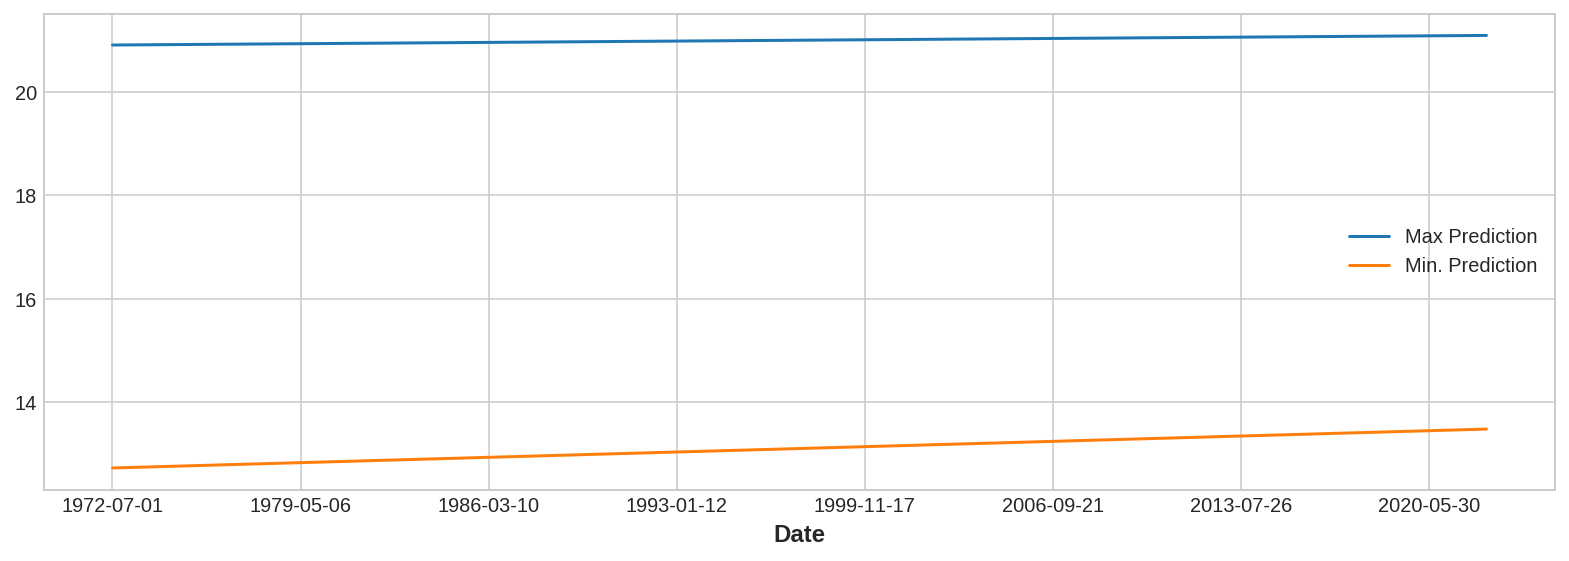

In [64]:
y_pred_trend.plot()

Numerical values for the slopes of those lines can be calculated by coef_ method.

In [65]:
print(model_min_trend.coef_)
print(model_max_trend.coef_)

[1.27288788e+01 4.11383858e-05]
[2.08983116e+01 1.01465494e-05]


as seen with coef_ values,

Trend of minimum temperatures is 41.13 μC*t + 12.7 C

Trend of maximum Temperatures is 10.14 μC*t + 20.89 C

(m --> (1/1000), C --> Celcius, t --> number of days passed from 1972, July)

This means minimum temperatures are increasing **4 times more (2.47 mC/0.70 mC)** than maximum temperatures. This fact implies that day and night temperatures are getting closer. 

Over the 50 years period maximum daily temperatures have been increased by 50* 365.25 * 10.1 μC = 0.18 Celcius Degrees
Over the 50 years period minimum daily temperatures have been increased by 50* 365.25 * 41.1 μC = 0.70 Celcius Degrees

### Seasonality

Seasonality is the regular periodic change in the mean of time series. For weather prediction, a typical seasonality time frame would be a year.

Seasonal indicators can be used to predict short term(daily, weekly) seasonal patterns, while Fourier series can be used for discovering longer time(a few months or more) seasonal patterns.

A periodogram is an estimate of the spectral density of signals ([Source](https://en.wikipedia.org/wiki/Periodogram)). 

It can be used to discover which frequency(i.e. annual, monthly, weekly etc.) is dominant in the time series.

plot_periodogram function below is for discovering which frequencies are more influential in the seasonal patterns observed in weather data. 

In [67]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

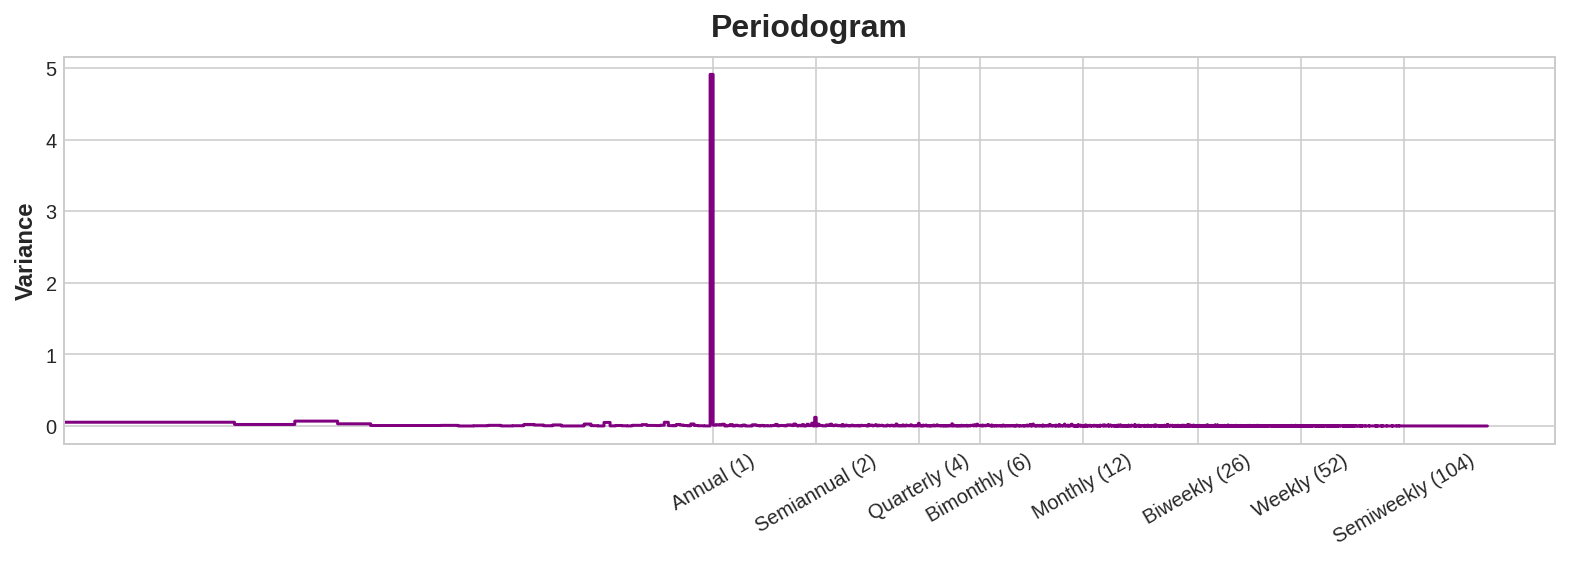

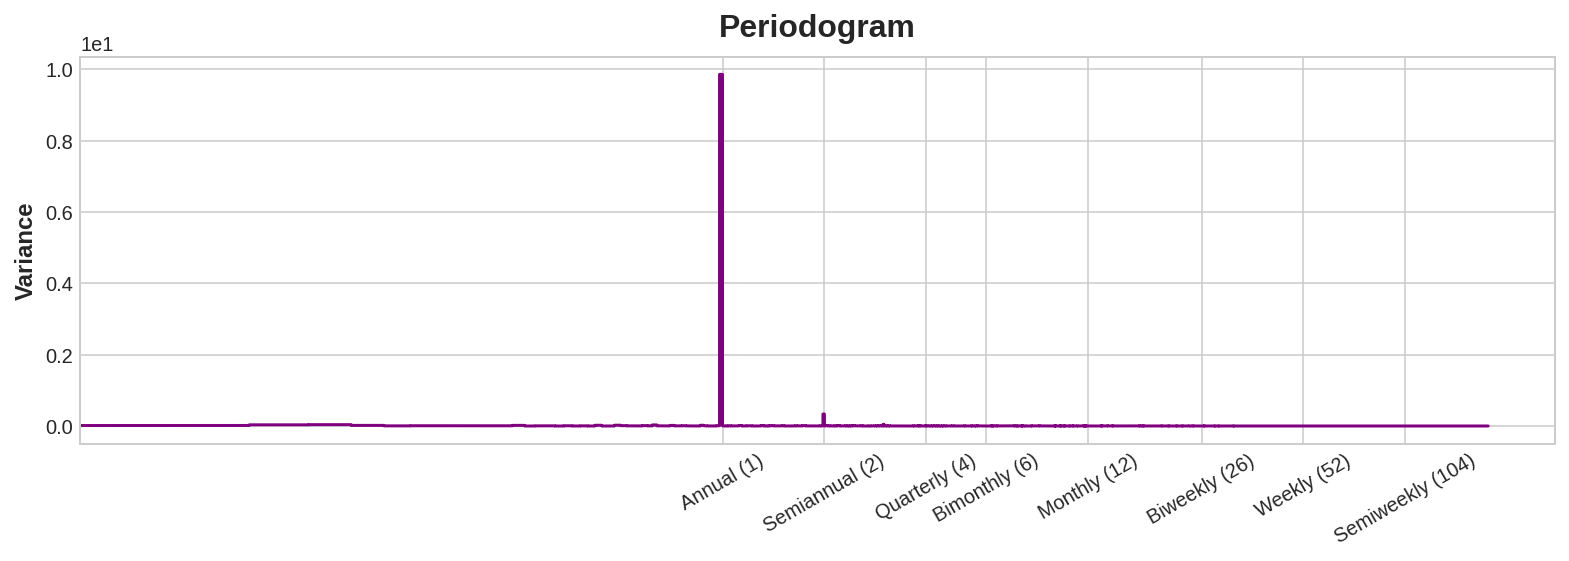

In [68]:
plot_periodogram(weather_data["TMax"+unit])
plt.show()
plot_periodogram(weather_data["TMin"+unit])
plt.show()

Two periodograms have been drawn above. The graph on the top shows the periodogram for maximum temperature, and the one below shows the periodogram for minimum temperature.

As seen from Periodogram graphs above, weather data shows a strong annual seasonality pattern.

Currently, the index is in the type of object; to work with CalenderFourier, it needs to converted into pd.datetime datatype. Next cell makes the conversion.

In [69]:
weather_data.index = weather_data.index.map(lambda x: pd.to_datetime(x))

A fourier series is the sum of some trigonometric functions. For the purposes of weather forecasting, 10 sinus/cosinus pairs will be used.

In [70]:
fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=weather_data.index.to_period(),
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True                    # drop terms to avoid collinearity
)

X = dp.in_sample()

Two linear regression models have been used to predict Maximum and Minimum temperatures.

In [71]:
# Defining targets
y_max = weather_data["TMax"+unit]
y_min = weather_data["TMin"+unit]

# Defining models
model_max = LinearRegression(fit_intercept = False)
model_min = LinearRegression(fit_intercept = False)

# Fitting models over existing data
model_max.fit(X, y_max)
model_min.fit(X, y_min)

# Defining Forecast Horizon
X_fore = dp.out_of_sample(steps=200)

# Making predictions on historical data
y_pred_max_seasonal = pd.Series(model_max.predict(X), index = y_max.index)
y_pred_min_seasonal = pd.Series(model_min.predict(X), index = y_min.index)

# Making forecasts
y_fore_max = pd.Series(model_max.predict(X_fore), X_fore.index)
y_fore_min = pd.Series(model_min.predict(X_fore), X_fore.index)

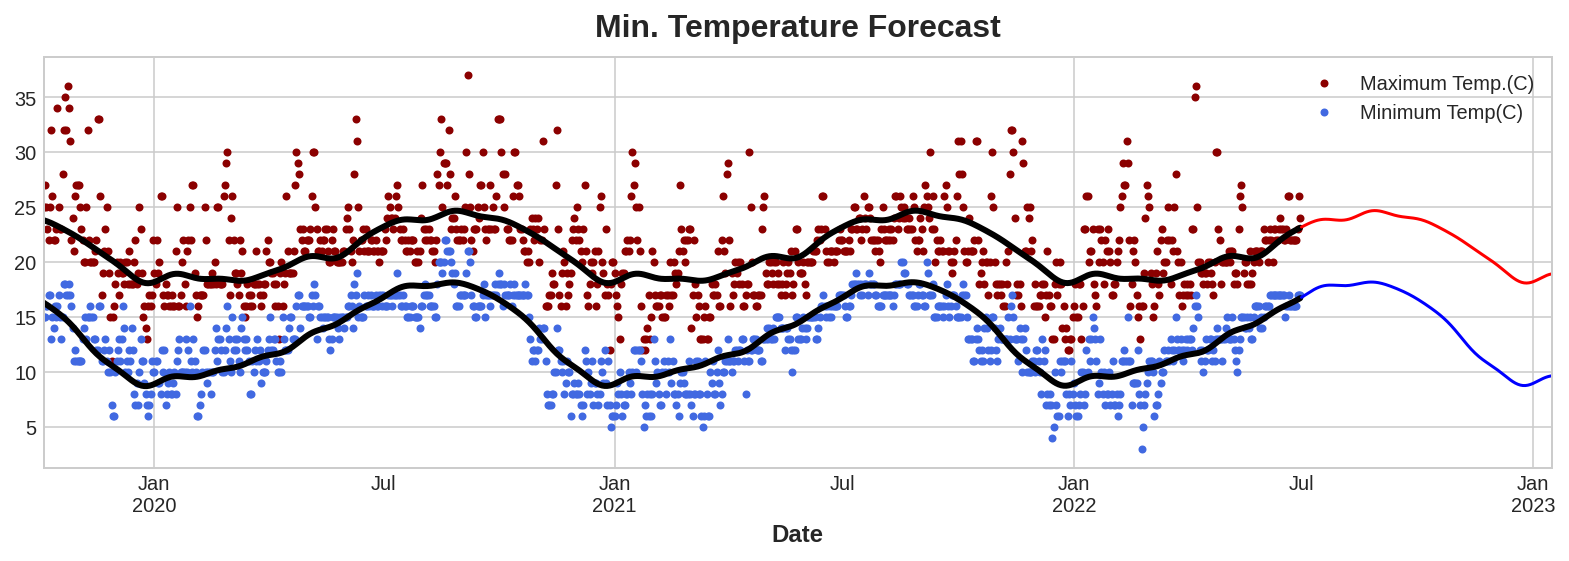

In [72]:
# Plotting
## Plotting last 1000 days to clearly see the data

### Drawing scatter points
ax = y_max[-1000:].plot(style=".", title="Max. Temperature Forecast", color="darkred")
ax = y_min[-1000:].plot(style=".", title="Min. Temperature Forecast", color="royalblue")

### Drawing the historically fitted lines
ax = y_pred_max[-1000:].plot(ax=ax, label="Seasonal", linewidth=3, color="black")
ax = y_pred_min[-1000:].plot(ax=ax, label="Seasonal", linewidth=3, color="black")

### plotting next 200 day forecasts in red
ax = y_fore_max.plot(ax=ax, label="Seasonal Forecast", color="red")
ax = y_fore_min.plot(ax=ax, label="Seasonal Forecast", color="blue")
plt.legend(["Maximum Temp.("+unit+")", f"Minimum Temp({unit})"],loc=1)

### Time Series as Features


#### Lag Series and Lag Plots

Lagged values for **maximum temperatures** will be calculated.

In [73]:
for i in range(1,4):
  # 3 lag columns for maximum temperature will be created
  weather_data["Lag_"+str(i)+"max"] = weather_data["TMax"+unit].shift(i)

  # 3 lag columns for minimum temperature will be created
  weather_data["Lag_"+str(i)+"min"] = weather_data["TMin"+unit].shift(i)

In [74]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

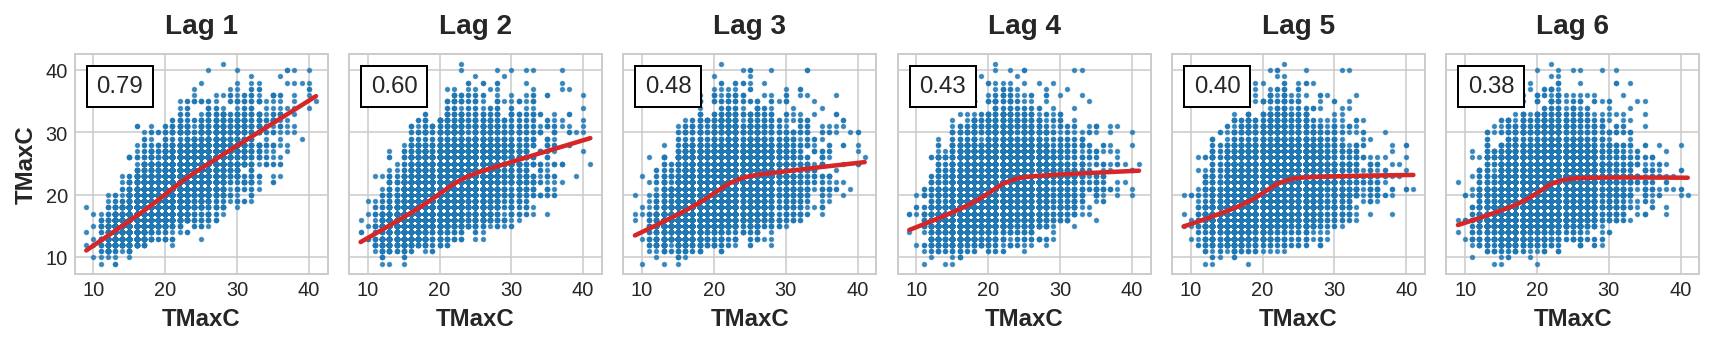

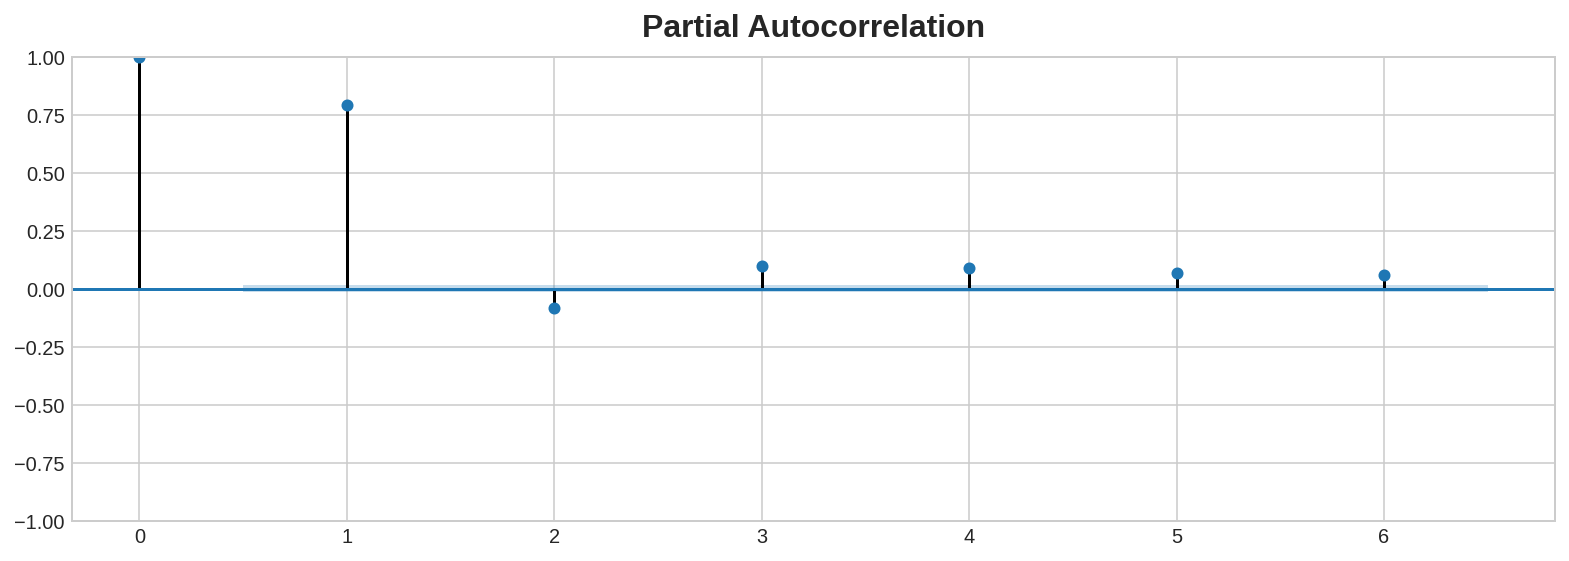

In [75]:
_ = plot_lags(weather_data["TMax"+unit])
_ = plot_pacf(weather_data["TMax"+unit], lags=6)

In [76]:
print("Mean: ",weather_data["TMaxC"].mean())
print("Median: ",weather_data["TMaxC"].median())

Mean:  20.990964845033403
Median:  21.0


The lag plots indicate that the relationship is mostly linear and the partial autocorrolation graph implies that only the first lag can be used to predict maximum temperature.

It can be observed from lag plots that graphs refract after some point. Also, the refraction becomes more clear as the number of lags inreases.

That's because linear relationship between target and lags only exist for temperatures below a limit (about 21 degrees celcius). That is observed because 21 degrees celcius is both mean and median of the series and there are much more data points closer to 21 degrees celcius.

The weather to stay in extreme temperatures gets less and less probable as more time goes by. Hence; as number of lags increases, the effect of non-linearity gets more clear.

A similar effect occurs for minimum temperatures at 13 degrees Celcius.

In [77]:
print("Mean: ",weather_data["TMinC"].mean())
print("Median: ",weather_data["TMinC"].median())

Mean:  13.104534005037783
Median:  13.0


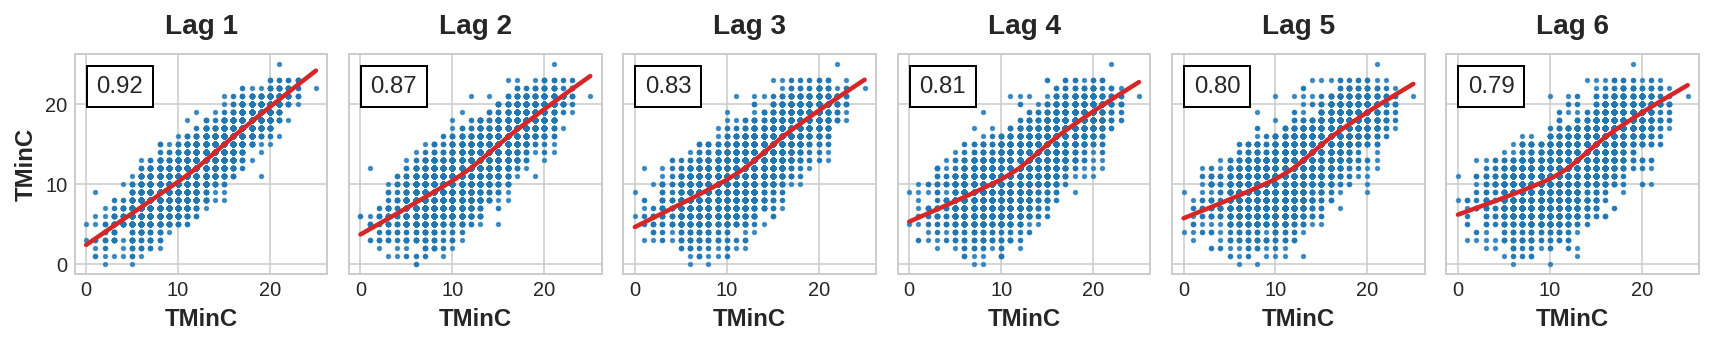

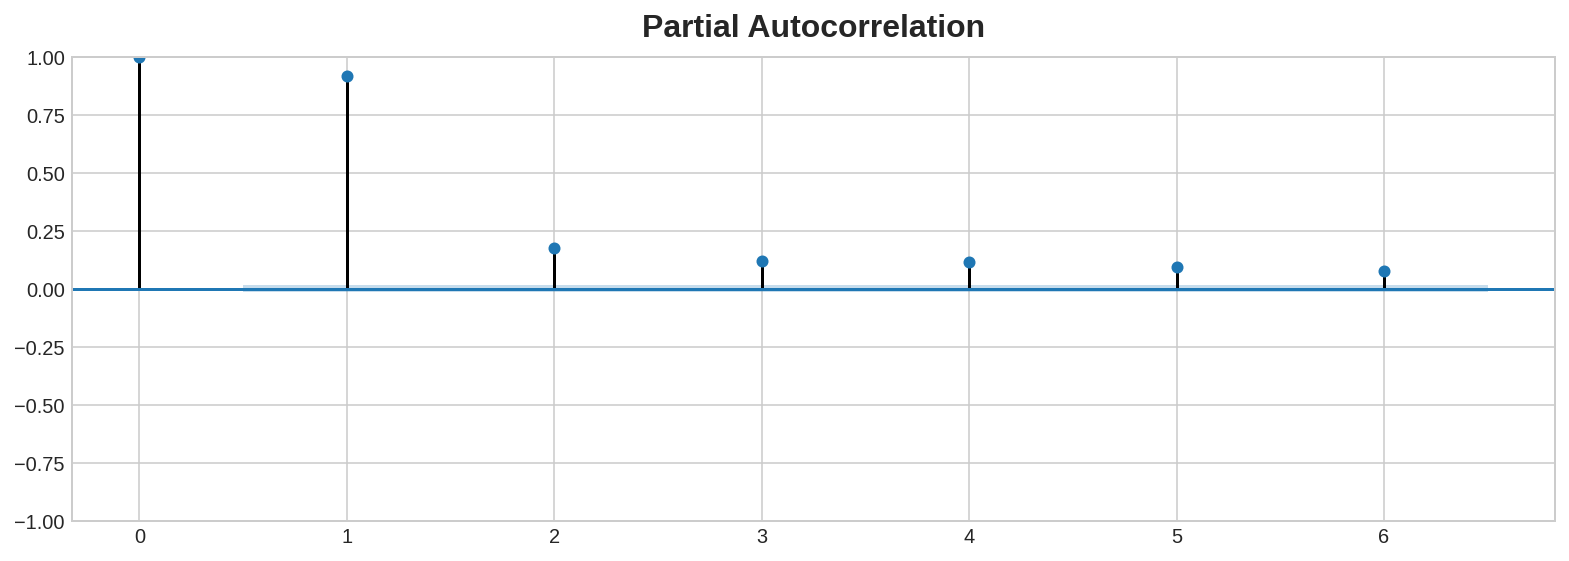

In [78]:
_ = plot_lags(weather_data["TMin"+unit])
_ = plot_pacf(weather_data["TMin"+unit], lags=6)

The above lag plots shows that minimum temperature also has a linear relation with its lags.

Partial autocorrelation map shows that first two lags are more correlated with the target.

In [79]:
y = weather_data["TMaxC"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 100, shuffle= False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_seasonal = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

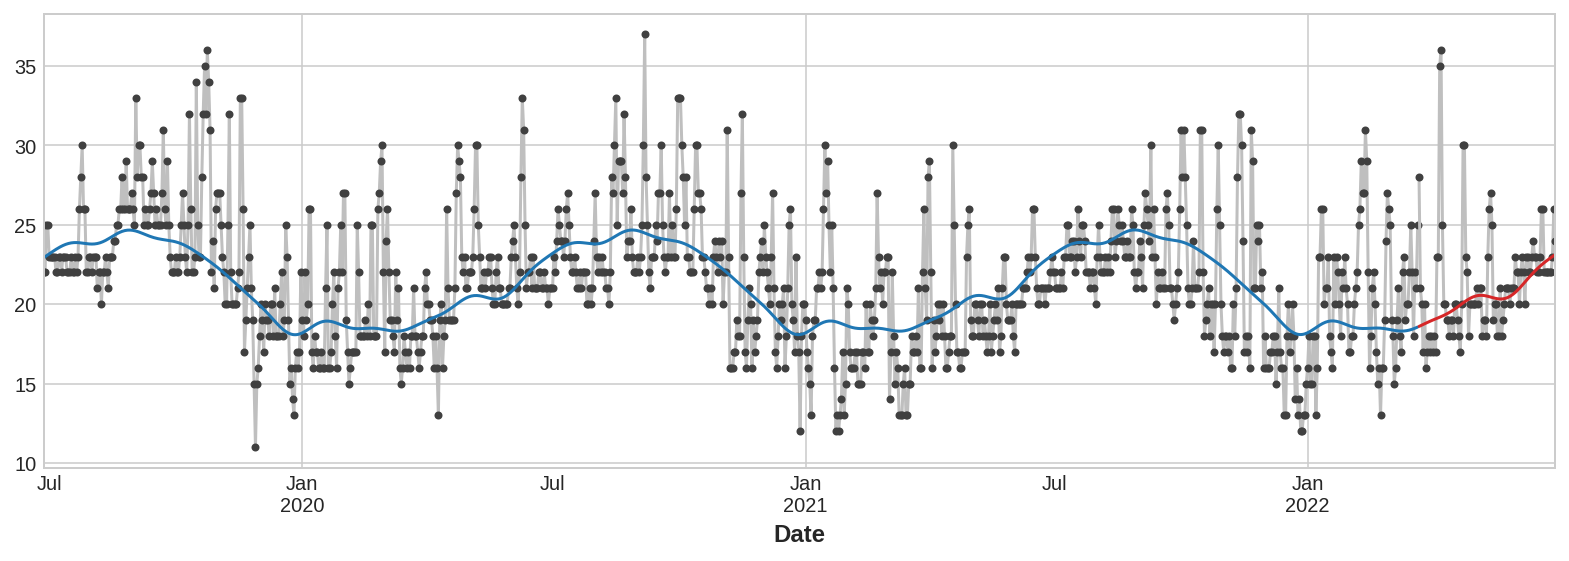

In [80]:
ax = y_train[-1000:].plot(**plot_params)
ax = y_pred_seasonal[-1000:].plot(ax=ax)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color="C3")

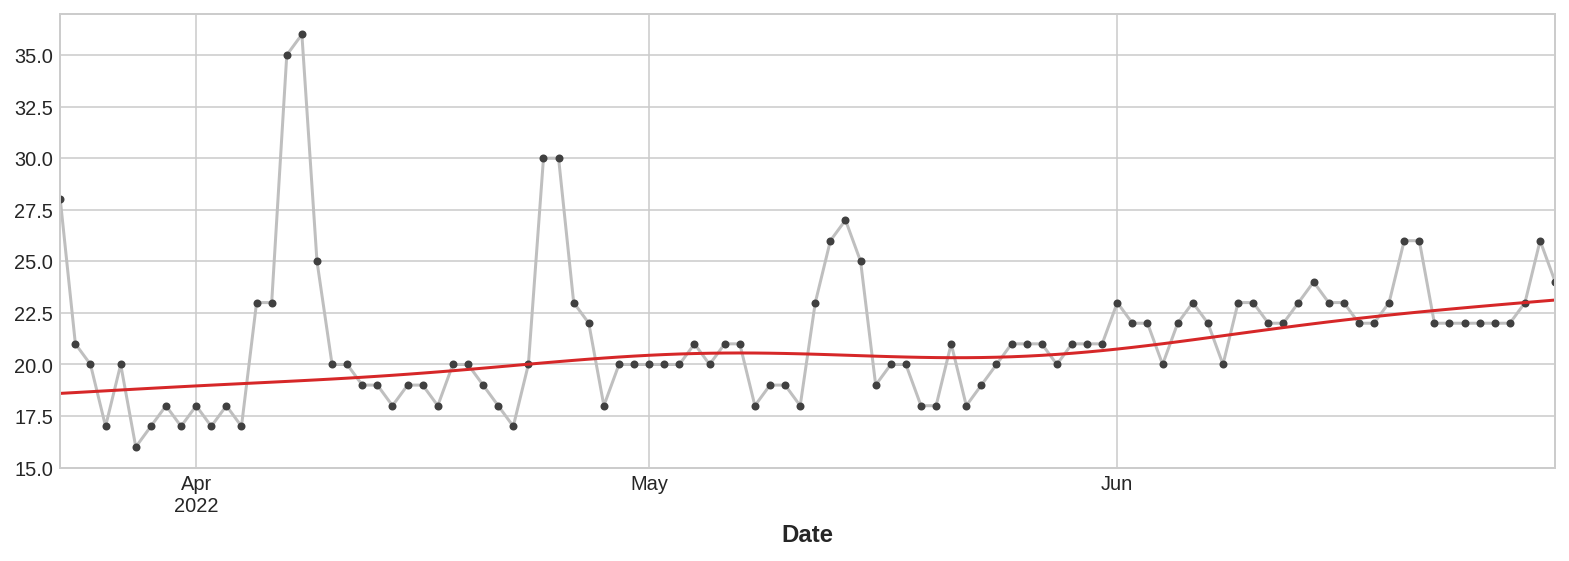

In [81]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color="C3")

In [82]:
print("MAE",mean_absolute_error(y_test,y_fore))


MAE 1.9659220866221574
